# The Question

---


<font face="Arial Black" size=3>
The input file (gm_8.nii) contains the **gray matter segmentation of 16 subjects**. The file is a 4D nifti (.nii). The first 3 dimensions are each volume (one per subject), the first 8 are healthy controls(0:7) and the second 8 are patients (8:15). The data is spatially normalized and aligned.
The problem is to find the differences between patients and controls. We know that the patients have some brain degeneration. The objective is to find the areas in which those differences are significant between groups and create a new .nii image(volume) that contains those differences.
</font>

---



<font face="Arial Black" size=3>
To begin, it is necessary to install all the required dependencies and import the essential libraries.

---


</fonts>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/MyDrive/Castillo/'

/content/drive/MyDrive/Castillo


In [ ]:
!pip install -r requirements.txt

In [4]:
import numpy as np
import nibabel as nib
from scipy import stats
from nilearn import plotting , datasets
from nilearn.plotting import view_img
import scipy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Exploratory Analysis

---



<font face="Arial Black" size=3>
First, we load the data and extract essential structural information from the image headers. We further ensure the quality of registration to the MNI atlas by visualizing the volumes alongside the MNI152 brain mask, confirming that they are all consistently aligned within the same coordinate system.
</font>

---



In [5]:
# Load the 4D NIfTI image
nifti_file = nib.load('./gm_8.nii')

# Access the header information for the first 3D MRI image (the 0th volume in the 4th dimension)
header_info = nifti_file.header

# Access specific information from the header, e.g., image dimensions
image_shape = header_info.get_data_shape()

# Print the image shape
print("Input Shape:", image_shape)

# Access voxel dimensions (in mm)
voxel_dimensions = header_info.get_zooms()

# Print voxel dimensions
print("Voxel Dimensions (mm):", voxel_dimensions)

Input Shape: (79, 95, 79, 16)
Voxel Dimensions (mm): (2.0, 2.0, 2.0, 1.0)


In [6]:
nifti_data = nifti_file.get_fdata()

# Define the group labels (0-7: Controls, 8-15: Patients)
controls_data = nifti_data[:, :, :, 0:8]
patients_data = nifti_data[:, :, :, 8:16]

In [7]:
# Create .nii files of patients and controls
controls_data_nii = nib.Nifti1Image(controls_data, nifti_file.affine)
patients_data_nii = nib.Nifti1Image(patients_data, nifti_file.affine)

In [8]:
print(header_info)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 4 79 95 79 16  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.4:ddd0a010'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 78.0
qoffset_y       : -112.0
qoffset_z       : -70.0
srow_x          : [-2.  0.  0

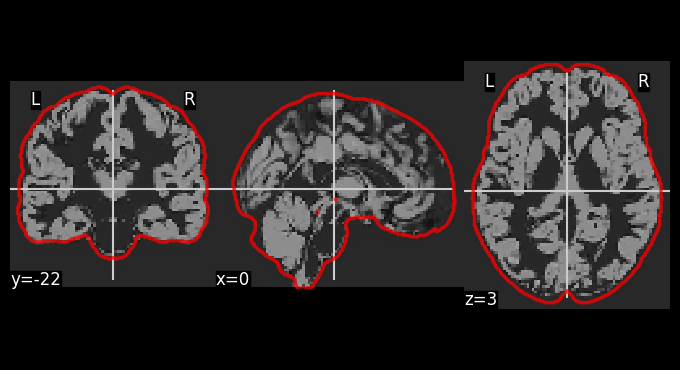

In [9]:
#Visulized the brain voloum with MNI152 mask
display = plotting.plot_anat(controls_data_nii.slicer[:,:,:,0])
display.add_contours(datasets.load_mni152_brain_mask(),
                     linewidths=2.5, levels=[.5],
                     cmap=plotting.cm.red_transparent)
plotting.show()

---
<font face="Arial Black"> We examined the values of each voxel and observed the presence of NaN (Not-a-Number) values within the patient data, which could potentially affect our future analyses. As these NaN values were located at the image periphery, we opted to replace them with a value of 0. In contrast, all the control group voxels remained unaffected, requiring no further manipulation.
</font>


In [10]:
print('Number of each Patient Nan voxels: ', np.sum(np.isnan(patients_data), axis=(0,1,2)))
print('Number of each control Nan voxels: ', np.sum(np.isnan(controls_data), axis=(0,1,2)))

Number of each Patient Nan voxels:  [  13    0 1814    0    0    0 1856    0]
Number of each control Nan voxels:  [0 0 0 0 0 0 0 0]



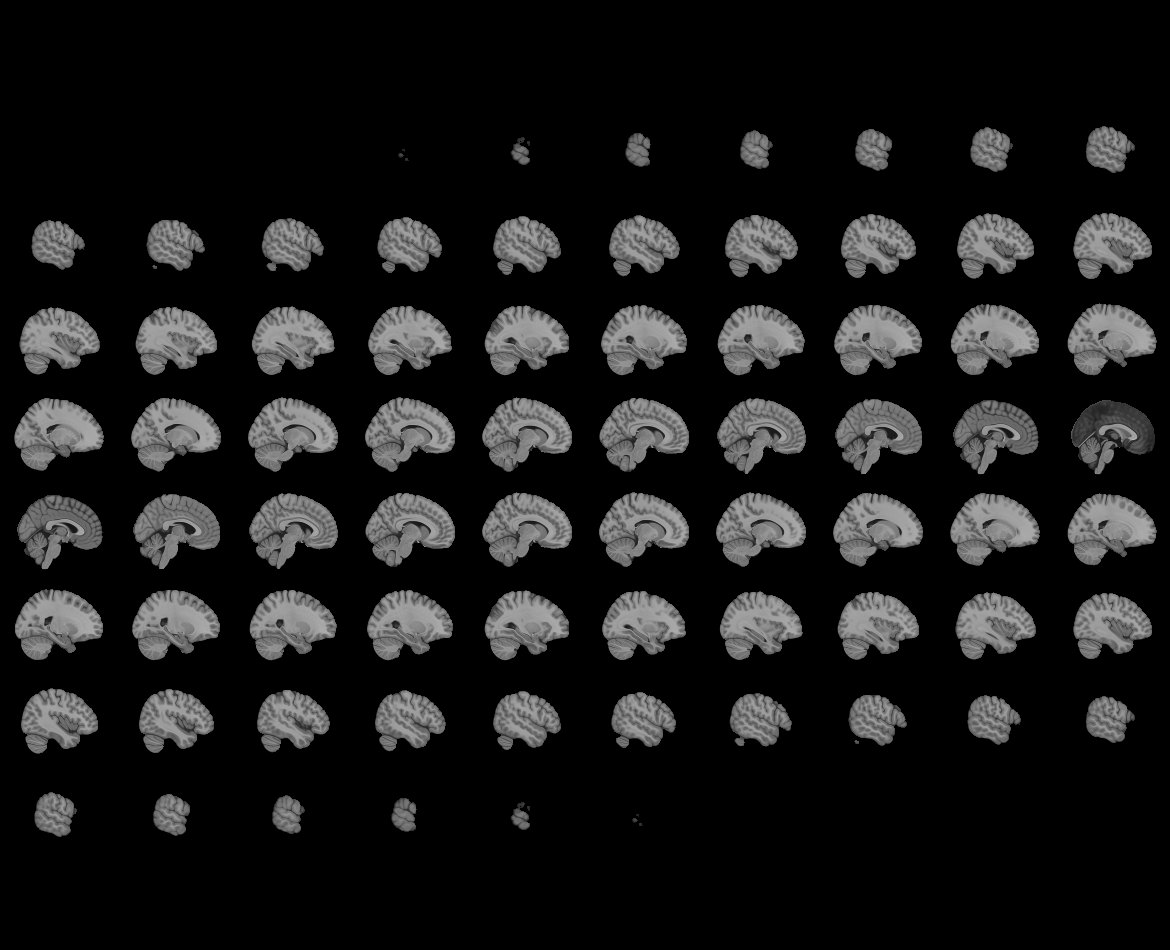
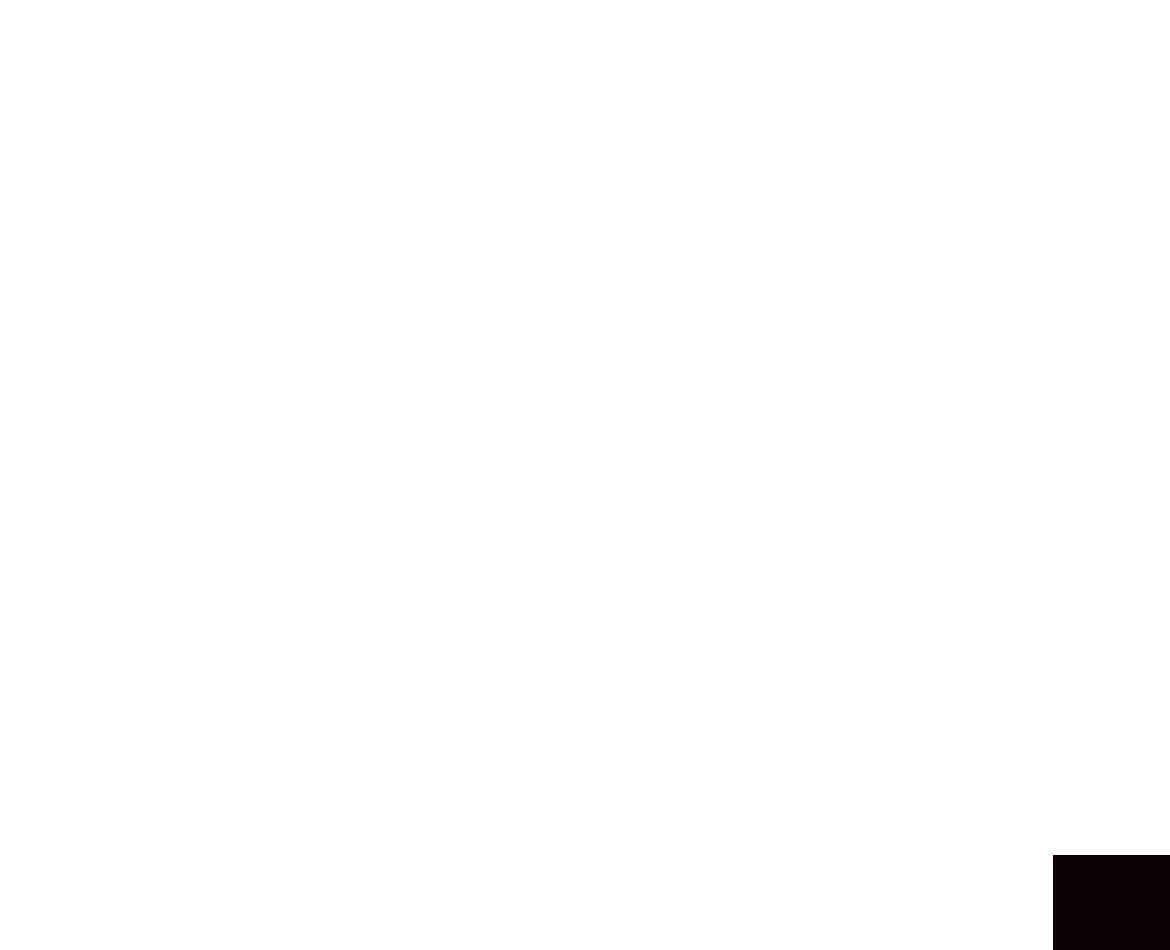

In [11]:
#Show example of Nan voxels for patient #2
p = patients_data.copy()
p[np.isnan(p)] = 1000
patients_data_nii = nib.Nifti1Image(p[:, :, :, 2], nifti_file.affine)
view_img(patients_data_nii, threshold=950)

In [12]:
# Replce Nan values with 0
patients_data[np.isnan(patients_data)] = 0
print('Number of each Patient Nan voxels: ', np.sum(np.isnan(patients_data), axis=(0,1,2)))

Number of each Patient Nan voxels:  [0 0 0 0 0 0 0 0]


---
<font face="Arial Black" size=3>
Next, we conducted calculations to determine the mean and standard deviation of volumes across the groups, followed by visual representations of the findings. In the same image slice, observable differences became apparent in specific brain regions between the two groups. These initial observations serve as a basis for our hypothesis, which we aim to substantiate through subsequent statistical techniques in the upcoming steps.
</font>

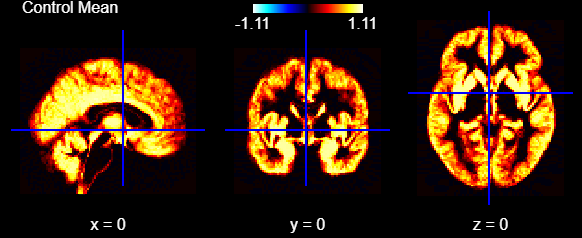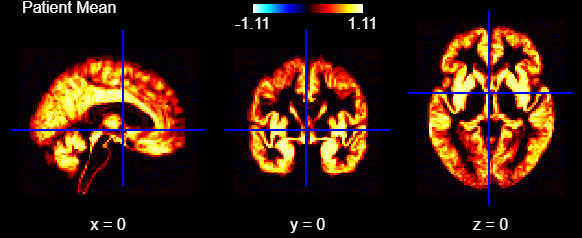

In [13]:
# Calculate the mean along the 4th dimension (across the 8 images)
mean_3d_control = np.mean(controls_data, axis=3)
mean_3d_patient = np.mean(patients_data, axis=3)

# Create a new 3D NIfTI image from the mean data
mean_nii_control = nib.Nifti1Image(mean_3d_control, nifti_file.affine)
mean_nii_patient = nib.Nifti1Image(mean_3d_patient, nifti_file.affine)


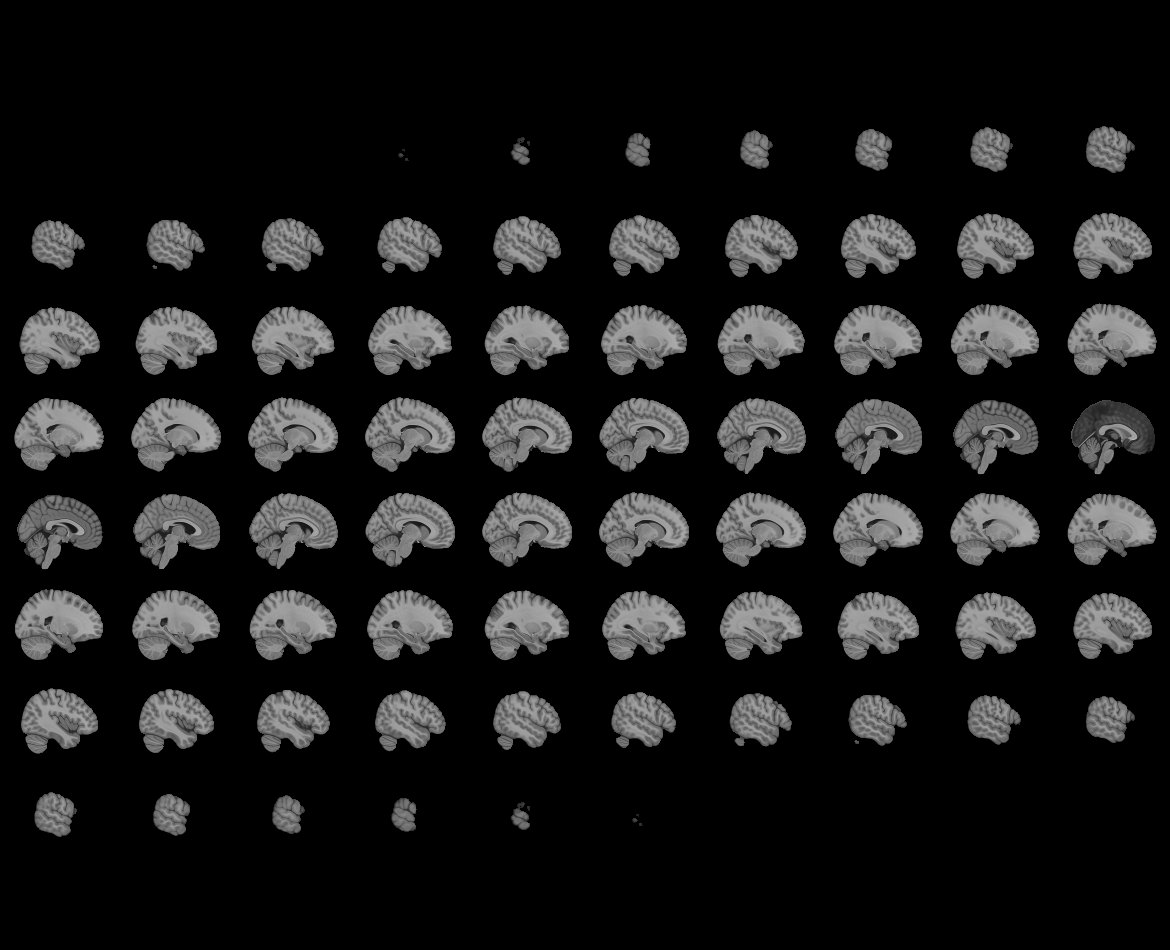
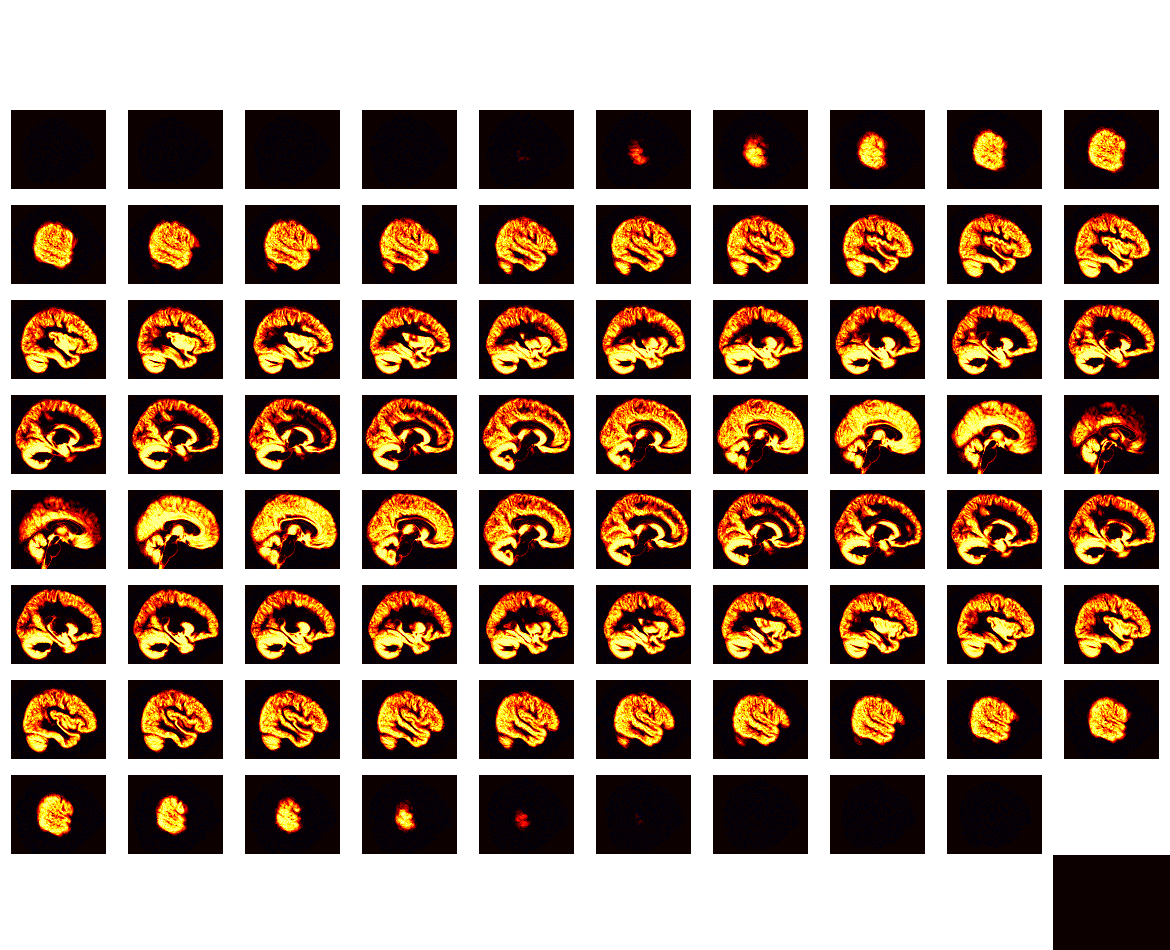

In [14]:
view_img(mean_nii_control, vmin=-1.11, vmax=1.11, threshold=None, title='Control Mean')


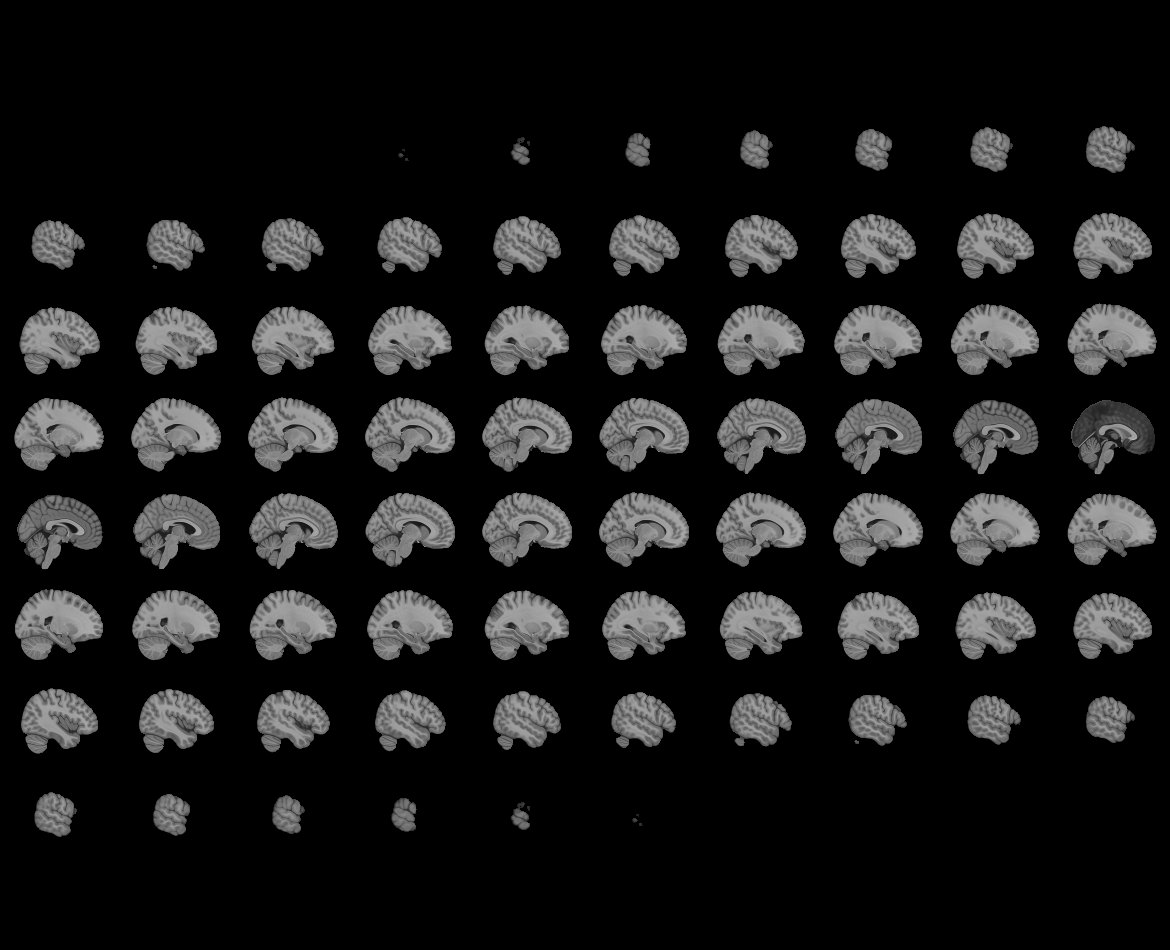
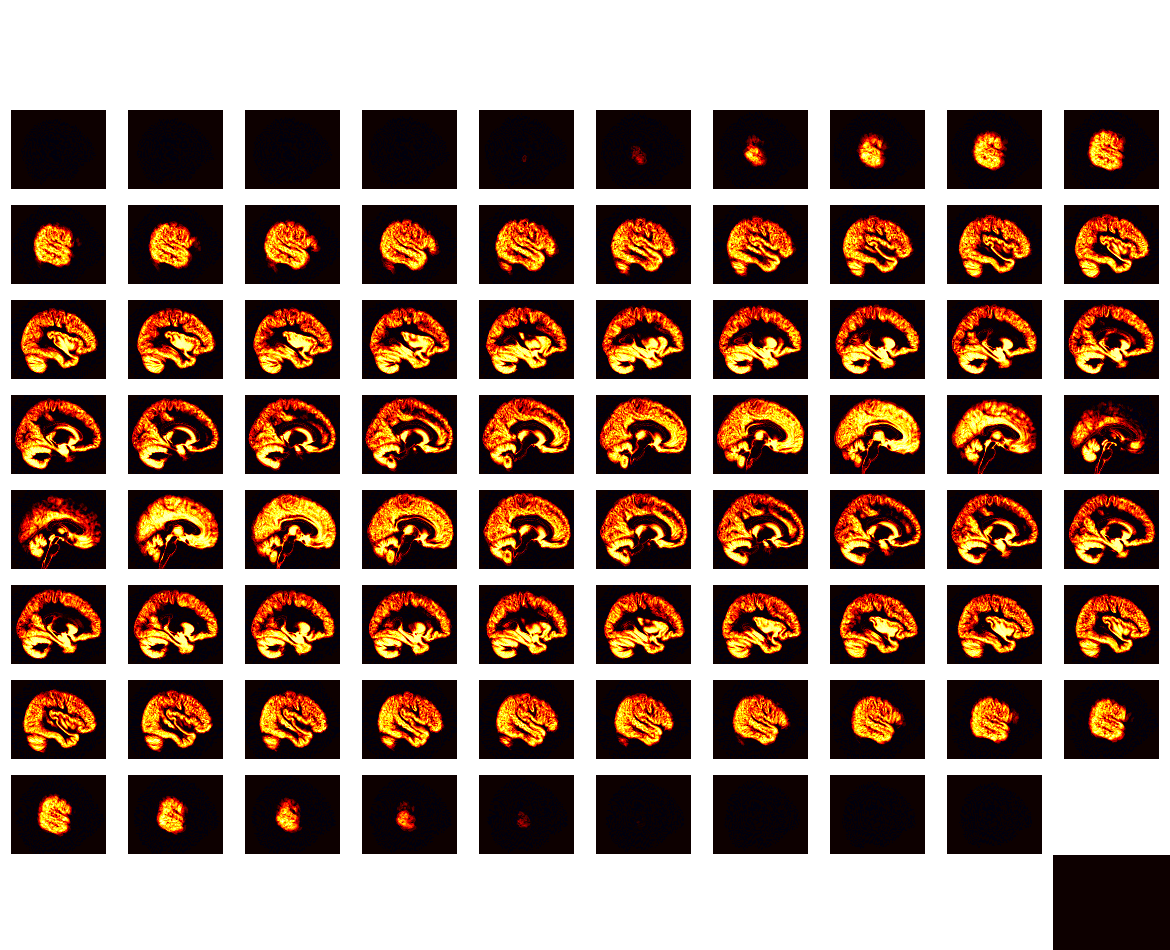

In [15]:
view_img(mean_nii_patient, vmin=-1.11, vmax=1.11, threshold=None, title='Patient Mean')

In [16]:
# Calculate the sd along the 4th dimension (across the 8 images)
sd_3d_control = np.std(controls_data, axis=3)
sd_3d_patient = np.std(patients_data, axis=3)

# Create a new 3D NIfTI image from the std data
sd_nii_control = nib.Nifti1Image(sd_3d_control, nifti_file.affine)
sd_nii_patient = nib.Nifti1Image(sd_3d_patient, nifti_file.affine)


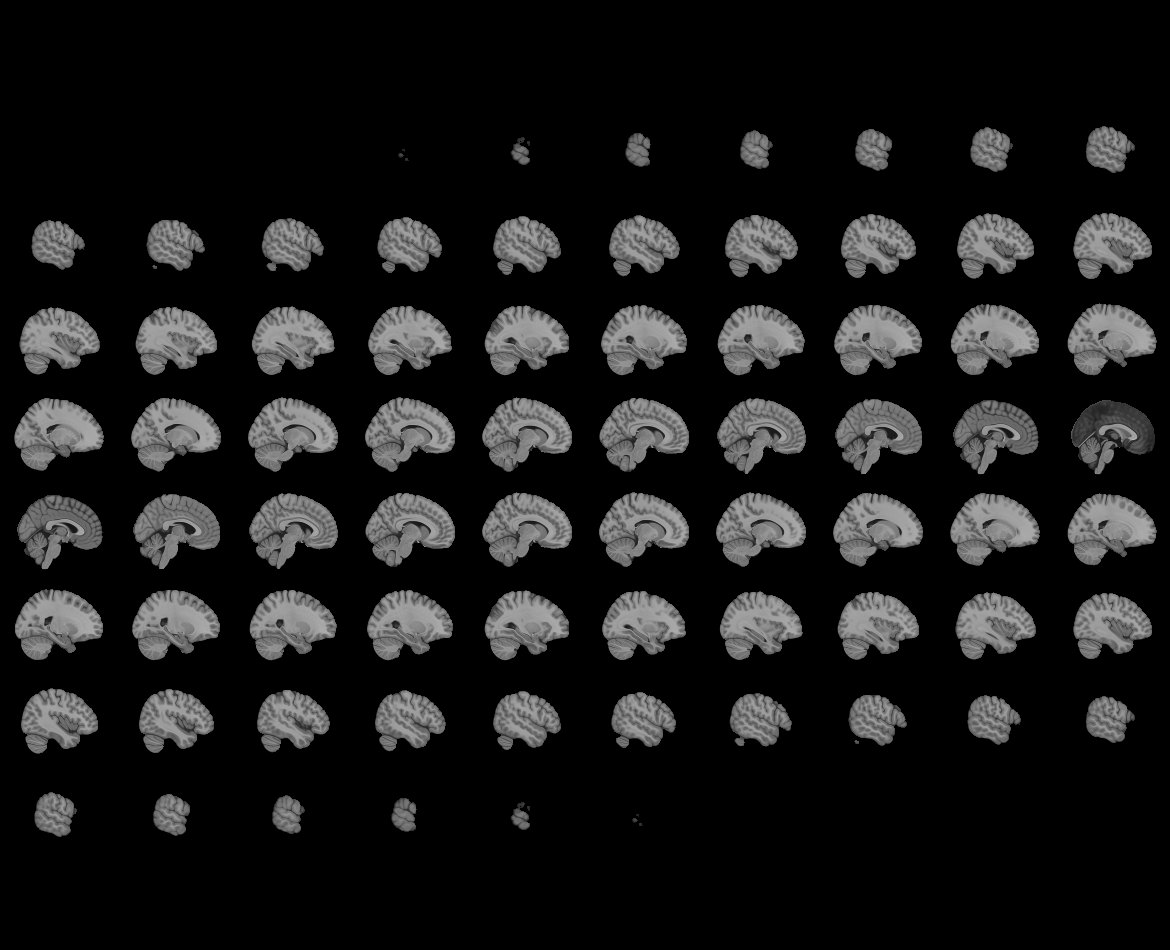
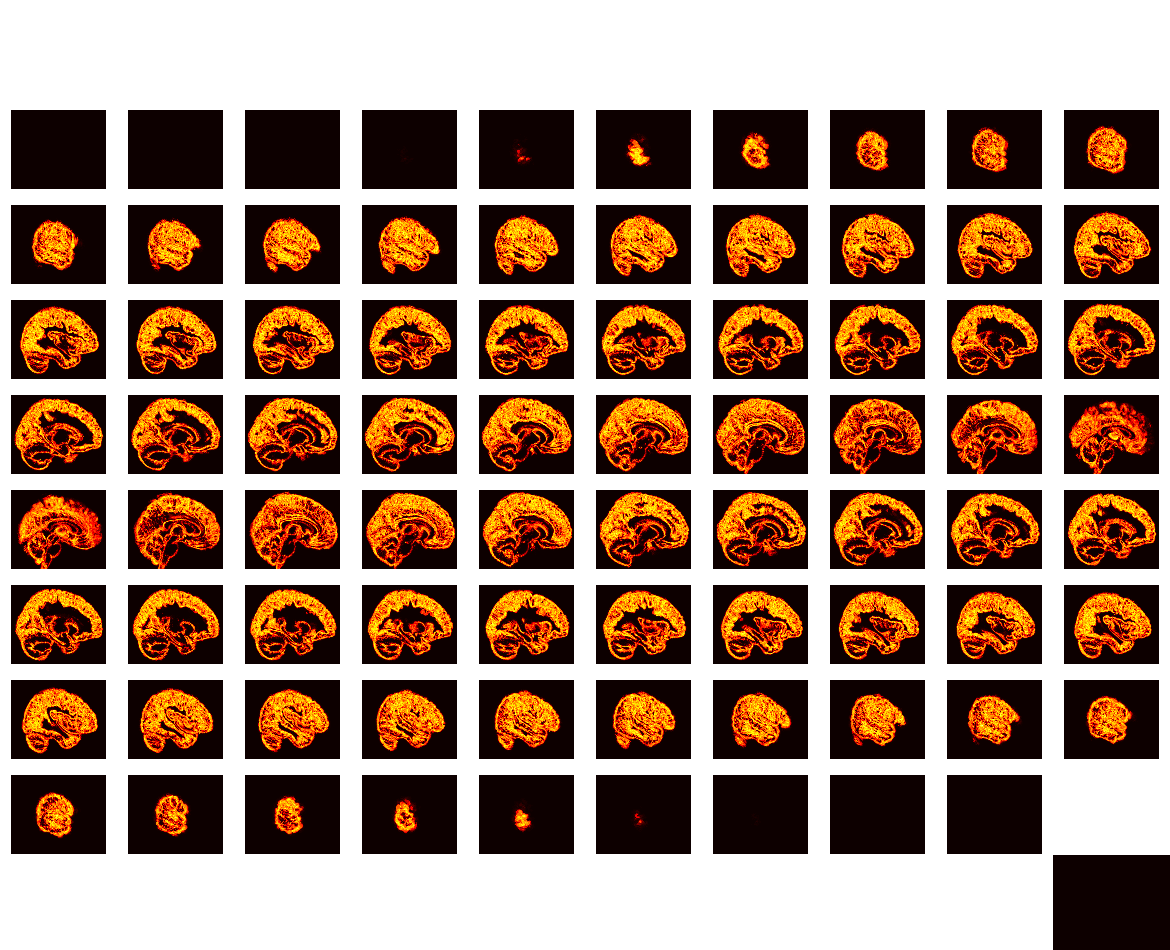

In [17]:
# Visualize the image using nilearn
view_img(sd_nii_control,threshold=None,vmin=-0.663,vmax=0.663, title='Controls Std')


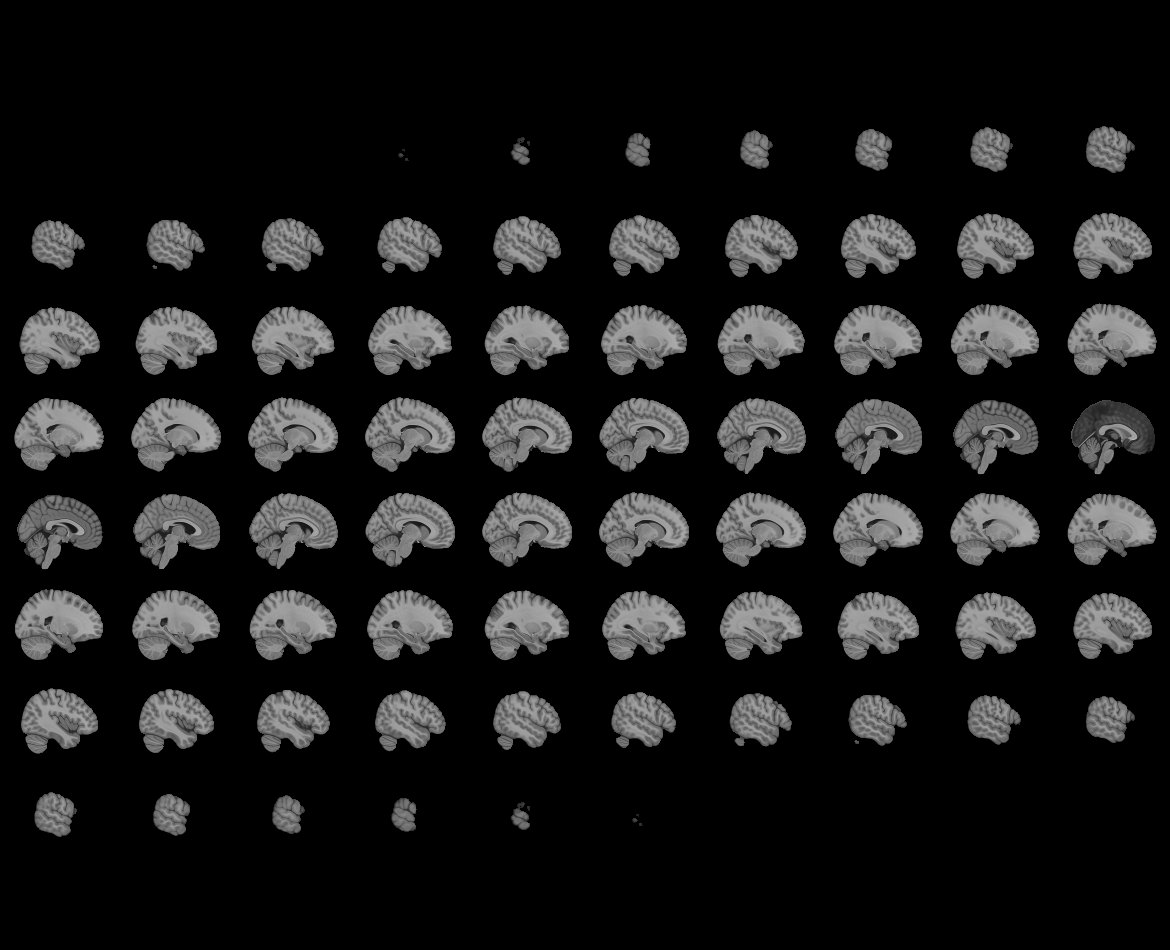
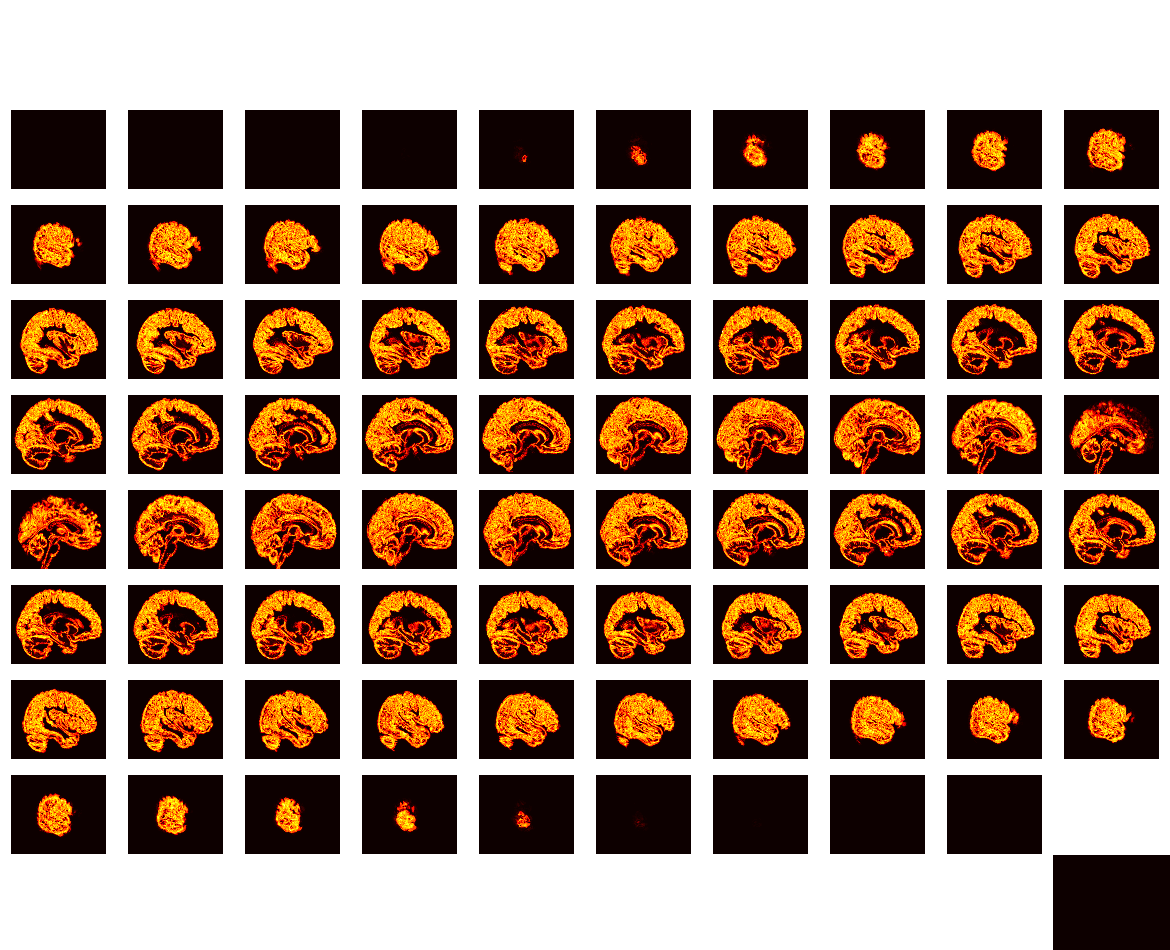

In [18]:
view_img(sd_nii_patient, threshold=None,vmin=-0.663,vmax=0.663, title='Patients Std')

---
<font face="Arial Black" size=3>
Controlling constraints when conducting statistical test on two groups is crucial to ensure the validity of the statistical analysis. Several key constraints must be considered, such as the assumption of normality for each group's data and the assumption of equal variances between the groups. These assumptions can be assessed through statistical tests like the Shapiro-Wilk test for normality and Levene's test for equal variances. Additionally, sample size is a critical factor; ensuring an adequate sample size for each group is necessary to maintain the t-test's robustness.
</font>

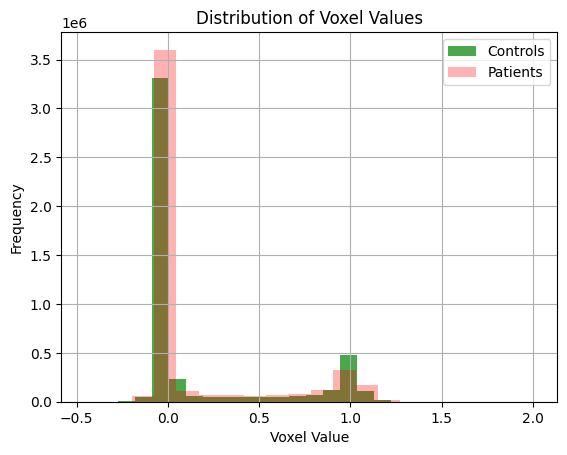

In [46]:
# Histogram of all voxels values across groups
data_flat = controls_data.flatten()
data_flat2 = patients_data.flatten()

# Create a histogram
plt.hist(data_flat, bins=20, color='green', label='Controls',alpha=0.7)
plt.hist(data_flat2, bins=20, color='red', label='Patients',alpha=0.3)


plt.xlabel('Voxel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Voxel Values')
plt.grid(True)
plt.legend()
plt.show()


In [42]:
res = scipy.stats.shapiro(controls_data.flatten())
res.statistic

0.582344651222229

In [43]:
res2 = scipy.stats.shapiro(patients_data.flatten())
res2.statistic

0.5537829399108887



---


<font face="Arial Black" size=3>
Once the constraints have been verified, we proceed with a voxel-wise t-test, followed by multiple comparison correction using the False Discovery Rate (FDR) method. Subsequently, we extract and save the volumetric data corresponding to a specific brain region that exhibits statistically significant differences between the two groups.
</font>

Significant differences saved as significant_differences.nii



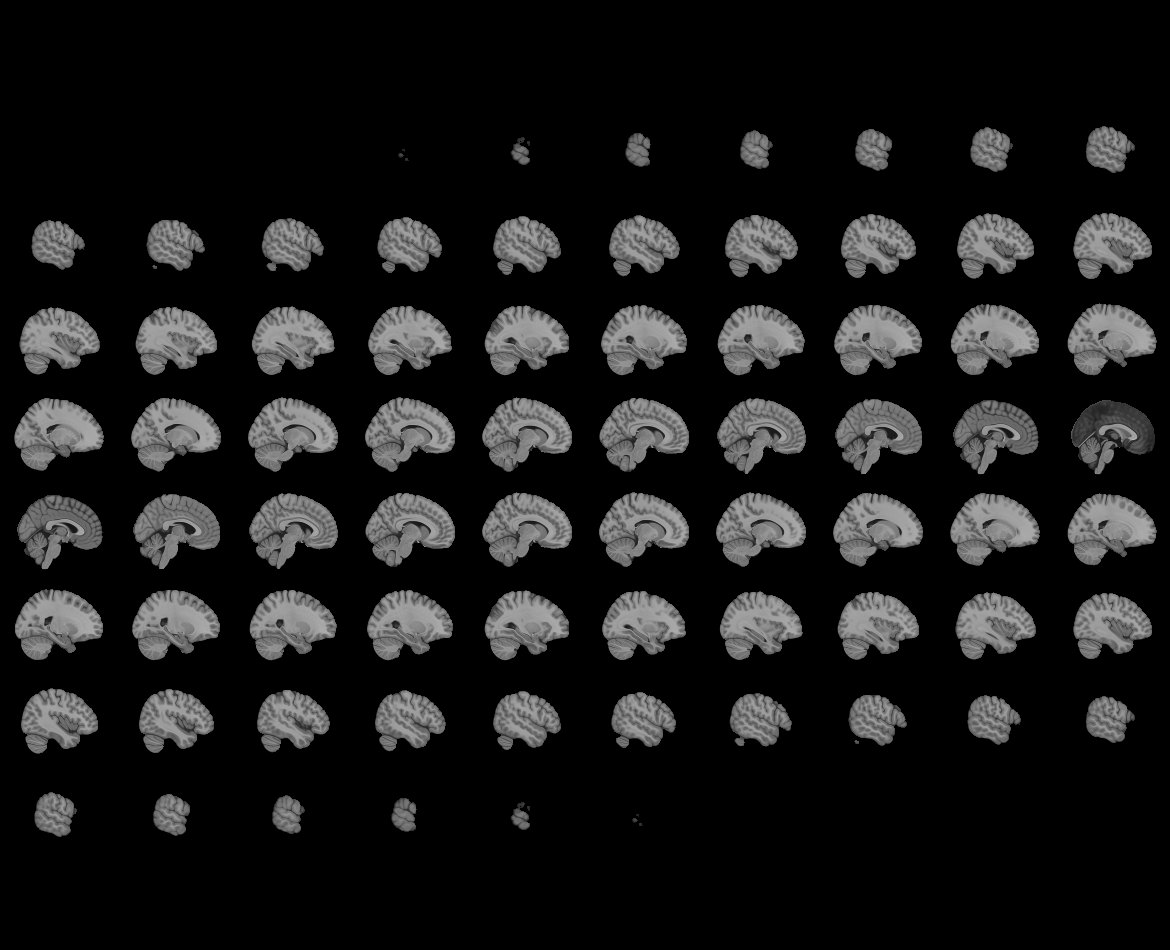
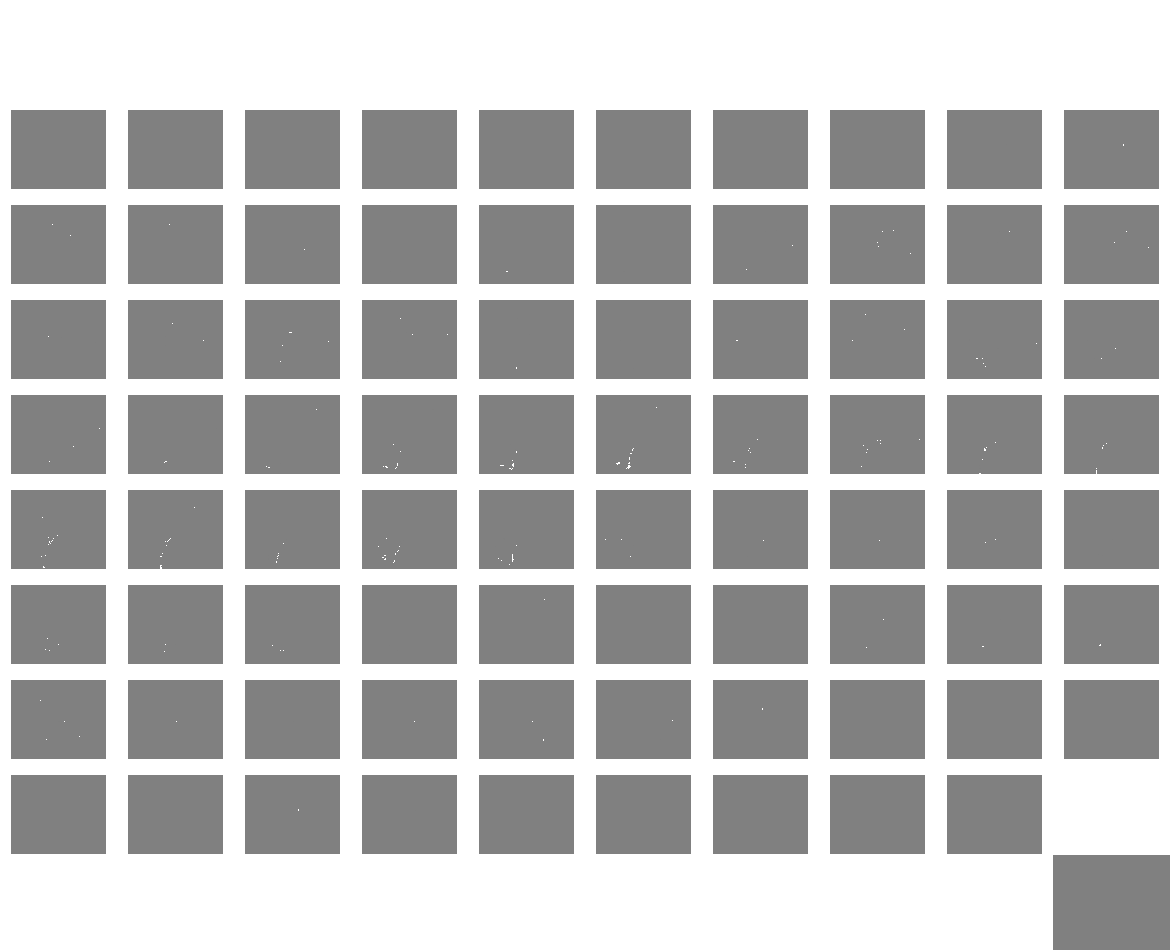

In [19]:
# Perform a voxel-wise statistaical test
t_statistic, p_values = stats.ttest_ind(controls_data, patients_data, axis=3)

# Define a significance threshold (e.g., p < 0.05)
significant_mask = p_values < 0.05
p_values[np.isnan(p_values)]=1

# Create a new NIfTI image from the significant differences
new_img = nib.Nifti1Image(significant_mask.astype(np.float32), nifti_file.affine)

# Save the new NIfTI image
output_file = "significant_differences.nii"
nib.save(new_img, output_file)

print("Significant differences saved as", output_file)

from statsmodels.stats.multitest import fdrcorrection


_ ,p_value_fdr = fdrcorrection(p_values.flatten(),alpha=0.5)
significant_mask_fdr = p_value_fdr.reshape((79, 95, 79)) < 0.05

new_img_fdr = nib.Nifti1Image(significant_mask_fdr.astype(np.float32), nifti_file.affine)


# Visualize the image using nilearn
view_img(new_img_fdr, threshold=None, cmap='gray', title='Significant differences')

---
<font face="Arial Black" size=3>
We subsequently aligned the identified region with an atlas using MRIcronGL, revealing that the majority of the area is situated within the cerebellum. In light of the findings presented in the article "[Parahippocampal Gray Matter Alterations in Spinocerebellar Ataxia Type 2 Identified by Voxel-Based Morphometry](https://https://scholar.google.ca/citations?view_op=view_citation&hl=en&user=rSrWYaIAAAAJ&citation_for_view=rSrWYaIAAAAJ:IjCSPb-OGe4C)" it is conceivable that the patients in our study may be attributed to the Spinocerebellar Ataxia Type 2 group. This particular type of ataxia is characterized by cerebellar degeneration, primarily affecting Purkinje cells, pontine nuclei, and the inferior olive. Symptoms typically manifest in the 3rd or 4th decade and encompass various motor and visuomotor disorders, including ataxia, dysmetria, dysarthria, dysdiadochokinesia, ophthalmoplegia, and saccade slowing.

In future endeavors, we intend to gain access to demographic data and functional MRI (fMRI) scans of these patients, thereby enabling more advanced statistical analyses. The potential to augment our dataset and harness deep learning techniques is a promising avenue for achieving our research goals. Methods like Convolutional Neural Networks (CNNs), autoencoders, and Generative Adversarial Networks (GANs) hold the potential to discern regions of divergence and identify associated dysfunctions, ushering in a more comprehensive understanding of these neurological conditions.
</font>

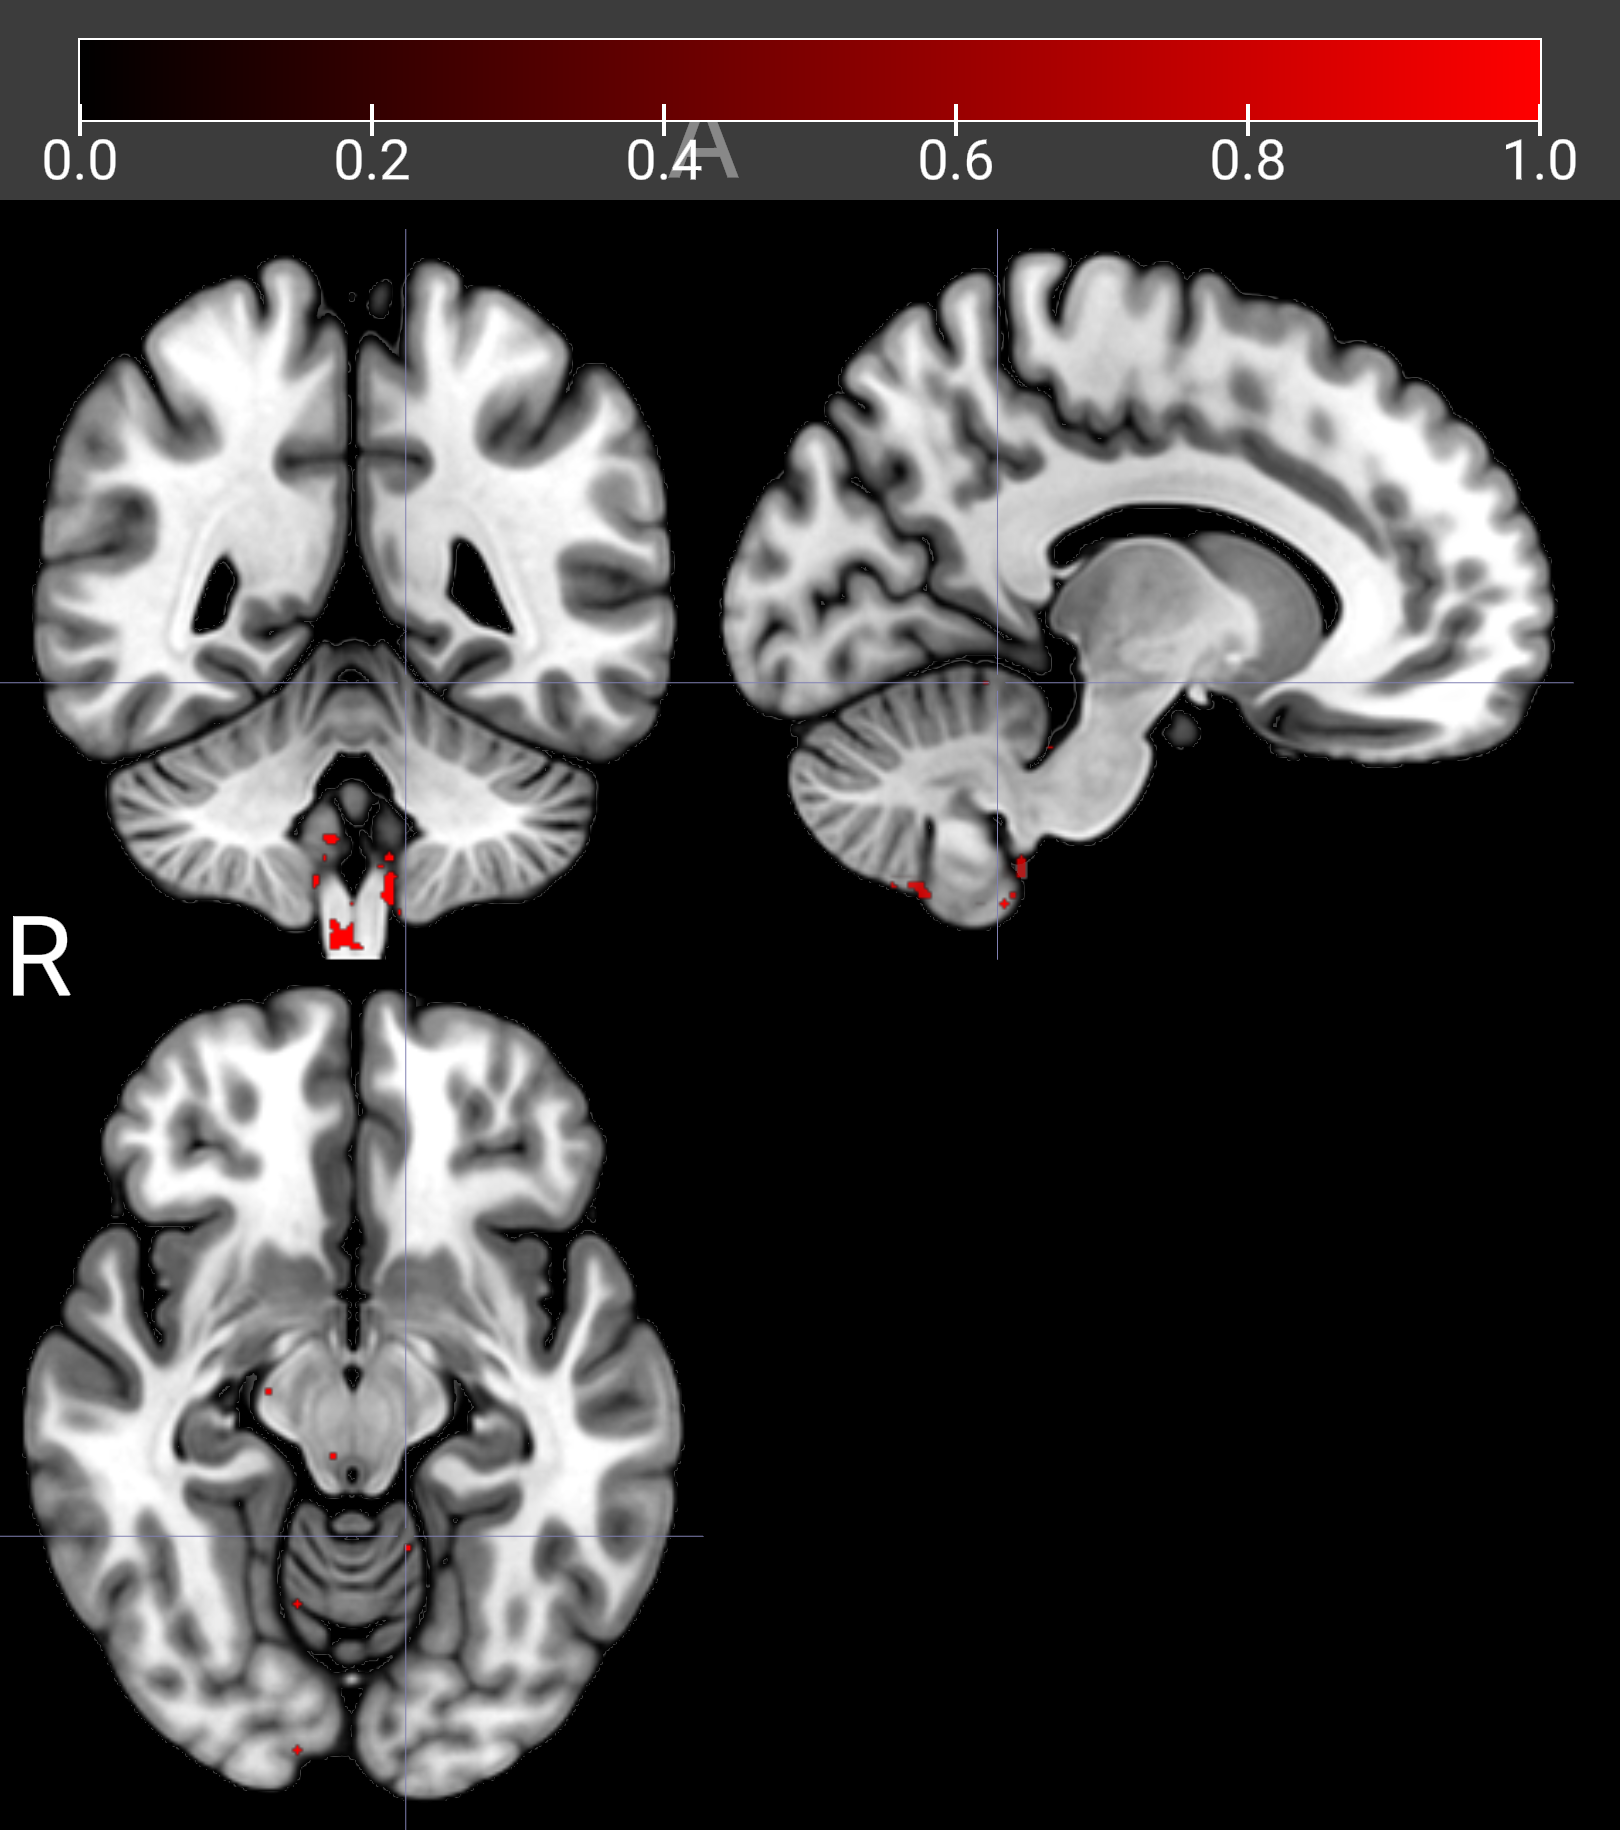